# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [2]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'CFS_PCP_forecasts_Sums_CMS.csv',sep=',')
tmp_data = pd.read_csv(dir+f'CFS_TMP_forecasts_Avgs_K.csv',sep=',')
evap_data = pd.read_csv(dir+f'CFS_EVAP_forecasts_Sums_CMS.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [3]:
X = pd.DataFrame({
    'su_pcp': pcp_data['sup_lake'],
    'er_pcp': pcp_data['eri_lake'],
    'on_pcp': pcp_data['ont_lake'],
    'mh_pcp': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_evap': evap_data['sup_lake'],
    'er_evap': evap_data['eri_lake'],
    'on_evap': evap_data['ont_lake'],
    'mh_evap': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_tmp': tmp_data['sup_lake'],
    'er_tmp': tmp_data['eri_lake'],
    'on_tmp': tmp_data['ont_lake'],
    'mh_tmp': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2
})
print(X)

           su_pcp      er_pcp      on_pcp       mh_pcp      su_evap  \
0      636.369837  300.622778   63.822853  2466.485814   902.196763   
1     2744.115733  375.388680  181.523281  2534.983177  1634.307881   
2     2605.488977  540.368897  271.529871  5117.100000  1859.368565   
3     2062.170153  677.219713  298.480950  2658.118961  1596.361713   
4     1852.993242  532.976397  292.464141  2550.001095  2662.666146   
...           ...         ...         ...          ...          ...   
1652  1819.704887  220.648784  124.018278  1898.963731  2231.944950   
1653  2147.244782  488.056176  252.052768  2548.175888  1623.688688   
1654  1009.261401  831.451059  407.920721  4053.483334   908.114640   
1655  1052.402441  476.829679  226.677355  2130.220673   332.067561   
1656  2372.512870  328.671750  256.712089  2006.727180   304.199602   

         er_evap     on_evap      mh_evap      su_tmp      er_tmp      on_tmp  \
0     591.158547  318.590900  2998.510730  289.981428  293.224596 

Standardize the data

In [4]:
# Standardize the data
#scaler = StandardScaler()
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [14]:
# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])
print(df_y_pred)

          su_evap    su_precip    su_runoff      er_evap    er_precip  \
0     1775.852564  2205.073915   667.852044  1780.878349   743.879967   
1     2927.291608  3385.425698   963.921873  2172.931528   775.921694   
2     3646.347393  2754.085146   786.748045  1941.138255  1010.915359   
3     3489.570614  1846.491052  1025.447811  1431.822888  1033.268401   
4     4533.191656  1700.987553   702.731223  1078.491102   765.387146   
...           ...          ...          ...          ...          ...   
1652  2707.449154  1733.476541   603.016265   362.434008   337.444488   
1653  3029.242364  1826.231120   759.840498   625.751133   712.008778   
1654  2208.789645   965.756464  1049.440486   789.469683  1251.963928   
1655  1588.009810  1287.001615  1092.775817  1271.878648   841.373974   
1656  1072.920658  3006.050217  1285.084030  1570.458235   800.103468   

        er_runoff     on_evap   on_precip    on_runoff      mh_evap  \
0      338.840382  750.612855  408.287930   432.0890

In [15]:
df_y_pred['month'] = pcp_data['forecast_month'].astype(int)
df_y_pred['year'] = pcp_data['forecast_year'].astype(int)

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [16]:
current_month = datetime.now().month
current_year = datetime.now().year

filtered_y_pred = df_y_pred[
    (df_y_pred['year'] > current_year) |
    ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
]
filtered_y_pred.to_csv(dir+f'CNBS_forecasts.csv',sep=',',index=False)

print(filtered_y_pred)

          su_evap    su_precip    su_runoff      er_evap    er_precip  \
1     2927.291608  3385.425698   963.921873  2172.931528   775.921694   
2     3646.347393  2754.085146   786.748045  1941.138255  1010.915359   
3     3489.570614  1846.491052  1025.447811  1431.822888  1033.268401   
4     4533.191656  1700.987553   702.731223  1078.491102   765.387146   
5     3866.084660  1487.450988   628.432399   773.704762   589.609867   
...           ...          ...          ...          ...          ...   
1652  2707.449154  1733.476541   603.016265   362.434008   337.444488   
1653  3029.242364  1826.231120   759.840498   625.751133   712.008778   
1654  2208.789645   965.756464  1049.440486   789.469683  1251.963928   
1655  1588.009810  1287.001615  1092.775817  1271.878648   841.373974   
1656  1072.920658  3006.050217  1285.084030  1570.458235   800.103468   

        er_runoff     on_evap   on_precip    on_runoff      mh_evap  \
1      261.267232  858.267790  519.589237   441.8633

In [38]:
def mean_min_max(df,lake):
    mean = df.groupby(['year', 'month'])[lake].mean().reset_index()
    min = df.groupby(['year', 'month'])[lake].min().reset_index()
    max = df.groupby(['year', 'month'])[lake].max().reset_index()

    return mean, min, max

mean_su_evap, min_su_evap, max_su_evap = mean_min_max(filtered_y_pred,'su_evap')
mean_su_precip, min_su_precip, max_su_precip = mean_min_max(filtered_y_pred,'su_precip')
mean_su_runoff, min_su_runoff, max_su_runoff = mean_min_max(filtered_y_pred,'su_runoff')

mean_er_evap, min_er_evap, max_er_evap = mean_min_max(filtered_y_pred,'er_evap')
mean_er_precip, min_er_precip, max_er_precip = mean_min_max(filtered_y_pred,'er_precip')
mean_er_runoff, min_er_runoff, max_er_runoff = mean_min_max(filtered_y_pred,'er_runoff')

mean_on_evap, min_on_evap, max_on_evap = mean_min_max(filtered_y_pred,'on_evap')
mean_on_precip, min_on_precip, max_on_precip = mean_min_max(filtered_y_pred,'on_precip')
mean_on_runoff, min_on_runoff, max_on_runoff = mean_min_max(filtered_y_pred,'on_runoff')

mean_mh_evap, min_mh_evap, max_mh_evap = mean_min_max(filtered_y_pred,'mh_evap')
mean_mh_precip, min_mh_precip, max_mh_precip = mean_min_max(filtered_y_pred,'mh_precip')
mean_mh_runoff, min_mh_runoff, max_mh_runoff = mean_min_max(filtered_y_pred,'mh_runoff')


   year  month      er_evap
0  2024      9  1745.813979
1  2024     10  1754.469732
2  2024     11  1491.051512
3  2024     12   936.383917
4  2025      1   550.298078
5  2025      2   457.446736
6  2025      3   567.582802
7  2025      4   820.940714
8  2025      5  1209.321535
9  2025      6  1432.901255


In [69]:
su_cnbs_mean = mean_su_precip['su_precip'] + mean_su_runoff['su_runoff'] - mean_su_evap['su_evap']
su_cnbs_min = min_su_precip['su_precip'] + min_su_runoff['su_runoff'] - min_su_evap['su_evap']
su_cnbs_max = max_su_precip['su_precip'] + max_su_runoff['su_runoff'] - max_su_evap['su_evap']

er_cnbs_mean = mean_er_precip['er_precip'] + mean_er_runoff['er_runoff'] - mean_er_evap['er_evap']
er_cnbs_min = min_er_precip['er_precip'] + min_er_runoff['er_runoff'] - min_er_evap['er_evap']
er_cnbs_max = max_er_precip['er_precip'] + max_er_runoff['er_runoff'] - max_er_evap['er_evap']

on_cnbs_mean = mean_on_precip['on_precip'] + mean_on_runoff['on_runoff'] - mean_on_evap['on_evap']
on_cnbs_min = min_on_precip['on_precip'] + min_on_runoff['on_runoff'] - min_on_evap['on_evap']
on_cnbs_max = max_on_precip['on_precip'] + max_on_runoff['on_runoff'] - max_on_evap['on_evap']

mh_cnbs_mean = mean_mh_precip['mh_precip'] + mean_mh_runoff['mh_runoff'] - mean_mh_evap['mh_evap']
mh_cnbs_min = min_mh_precip['mh_precip'] + min_mh_runoff['mh_runoff'] - min_mh_evap['mh_evap']
mh_cnbs_max = max_mh_precip['mh_precip'] + max_mh_runoff['mh_runoff'] - max_mh_evap['mh_evap']

In [86]:
def plot_cnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(20, 10), sharex=True)#, sharey=True)
    axs = axs.flatten()
    
    row_labels = ['Lake Superior', 'Lake Mich-Huron', 'Lake Erie', 'Lake Ontario']
    column_labels = ['Precipitation [cms]', 'Evaporation [cms]', 'Runoff [cms]', 'CNBS [cms]']

    # Initialize lists to hold y min and max values to set y limits later
    y_limits = {
        'cnbs': [float('inf'), -float('inf')],
        'other': [float('inf'), -float('inf')],
    }

    # First pass to find the global min and max for each group
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        if i in [3, 7, 11, 13]:
            y_limits['cnbs'][0] = min(y_limits['cnbs'][0], min_val.min())
            y_limits['cnbs'][1] = max(y_limits['cnbs'][1], max_val.max())
        else:
            y_limits['other'][0] = min(y_limits['other'][0], min_val.min())
            y_limits['other'][1] = max(y_limits['other'][1], max_val.max())

    # Plot each dataset
    for i, (category, (mean, min_val, max_val)) in enumerate(data_dict.items()):
        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Mean')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_xlim(0, 9)  # Setting x-axis limits from 1 to 10
        #axs[i].set_ylim(0, max_val.max())
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i in [3, 7, 11, 15]:  # Apply y-limits
            axs[i].set_ylim(y_limits['cnbs'][0]-200, y_limits['cnbs'][1]+1000)
        else:
            axs[i].set_ylim(0, y_limits['other'][1]+200)

        if i >= 12:  # Set labels for the last subplot
            axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],
                                    calendar.month_abbr[df_y_pred['month'][2]], calendar.month_abbr[df_y_pred['month'][3]],
                                    calendar.month_abbr[df_y_pred['month'][4]], calendar.month_abbr[df_y_pred['month'][5]],
                                    calendar.month_abbr[df_y_pred['month'][6]], calendar.month_abbr[df_y_pred['month'][7]],
                                    calendar.month_abbr[df_y_pred['month'][8]], calendar.month_abbr[df_y_pred['month'][9]]])

    # Add row labels on the left side        
    for i in range(4):
            axs[i * 4].set_ylabel(row_labels[i], rotation=90, labelpad=10, fontsize=12)
    
    # Add column labels on the top
    for i in range(4):
        axs[i].set_title(column_labels[i], pad=10, fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'CNBS_forecasts.png', bbox_inches='tight')
    plt.show()


C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_19000\344088707.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_19000\344088707.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_19000\344088707.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[df_y_pred['month'][0]], calendar.month_abbr[df_y_pred['month'][1]],
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykern

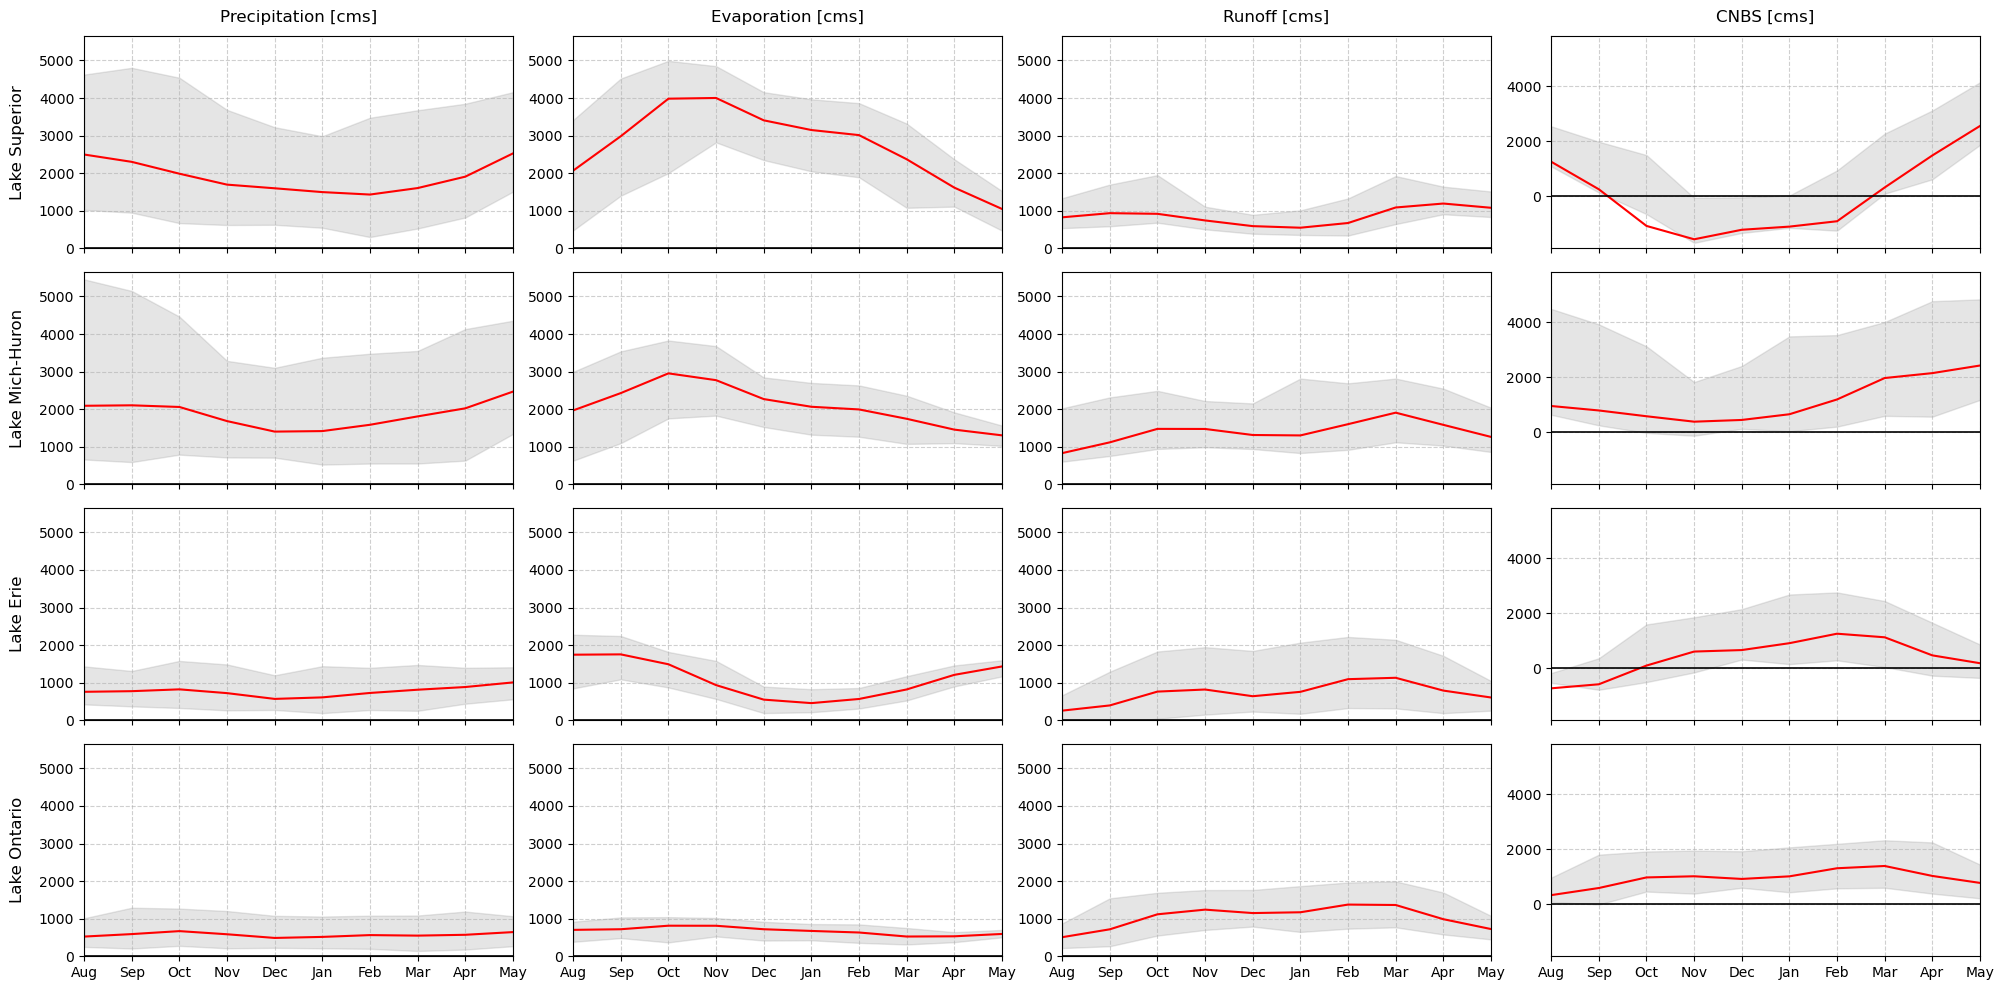

In [87]:
x_values = np.arange(len(mean_su_precip['su_precip']))  # x-axis values
data_dict = {
    'Superior P': (mean_su_precip['su_precip'], min_su_precip['su_precip'], max_su_precip['su_precip']),
    'Superior E': (mean_su_evap['su_evap'], min_su_evap['su_evap'], max_su_evap['su_evap']),
    'Superior R': (mean_su_runoff['su_runoff'], min_su_runoff['su_runoff'], max_su_runoff['su_runoff']),
    'Superior CNBS': (su_cnbs_mean, su_cnbs_min, su_cnbs_max),
    'Mich-Huron P': (mean_mh_precip['mh_precip'], min_mh_precip['mh_precip'], max_mh_precip['mh_precip']),
    'Mich-Huron E': (mean_mh_evap['mh_evap'], min_mh_evap['mh_evap'], max_mh_evap['mh_evap']),
    'Mich-Huron R': (mean_mh_runoff['mh_runoff'], min_mh_runoff['mh_runoff'], max_mh_runoff['mh_runoff']),
    'Mich-Huron CNBS': (mh_cnbs_mean, mh_cnbs_min, mh_cnbs_max),
    'Erie P': (mean_er_precip['er_precip'], min_er_precip['er_precip'], max_er_precip['er_precip']),
    'Erie E': (mean_er_evap['er_evap'], min_er_evap['er_evap'], max_er_evap['er_evap']),
    'Erie R': (mean_er_runoff['er_runoff'], min_er_runoff['er_runoff'], max_er_runoff['er_runoff']),
    'Erie CNBS': (er_cnbs_mean, er_cnbs_min, er_cnbs_max),
    'Ontario P': (mean_on_precip['on_precip'], min_on_precip['on_precip'], max_on_precip['on_precip']),
    'Ontario E': (mean_on_evap['on_evap'], min_on_evap['on_evap'], max_on_evap['on_evap']),
    'Ontario R': (mean_on_runoff['on_runoff'], min_on_runoff['on_runoff'], max_on_runoff['on_runoff']),
    'Ontario CNBS': (on_cnbs_mean, on_cnbs_min, on_cnbs_max)
}

plot_cnbs_forecast(x_values, data_dict)